# Feature Engineering for Cryptocurrency Forecasting

This notebook demonstrates the feature engineering process for cryptocurrency price prediction.

**Make your data module importable**

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

# This allows:
# from src.data.data_loader import CryptoDataLoader
# This is the correct approach for notebooks

# %load_ext autoreload
# %autoreload 2

In [2]:
# Import necessary libraries
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Import our modules
from data.data_loader import CryptoDataLoader
from data.feature_engineering import FeatureEngineer
from data.preprocessor import DataPreprocessor
from utils.helpers import calculate_returns, calculate_volatility

## 1. Load Data

In [3]:
# Initialize data loader
loader = CryptoDataLoader('../data/raw')

# Load Bitcoin data for the last year
ticker = 'BTC-USD'
data = loader.get_latest_data(ticker, days=365)

print(f"Loaded {len(data)} records for {ticker}")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")

# Display basic info
print("\nData Info:")
print(data.info())

# Display first few rows
print("\nFirst 5 rows:")
print(data.head())

Loaded 365 records for BTC-USD
Date range: 2025-01-15 to 2026-01-14

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2025-01-15 to 2026-01-14
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   365 non-null    float64
 1   High    365 non-null    float64
 2   Low     365 non-null    float64
 3   Open    365 non-null    float64
 4   Volume  365 non-null    int64  
 5   Ticker  365 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 20.0+ KB
None

First 5 rows:
                    Close           High            Low           Open  \
Date                                                                     
2025-01-15  100504.492188  100697.234375   96501.640625   96534.046875   
2025-01-16   99756.906250  100781.585938   97364.445312  100505.296875   
2025-01-17  104462.039062  105884.226562   99948.906250  100025.765625   
2025-01-18  104408.070312  104913.203125  102226

## 2. Basic Price Features

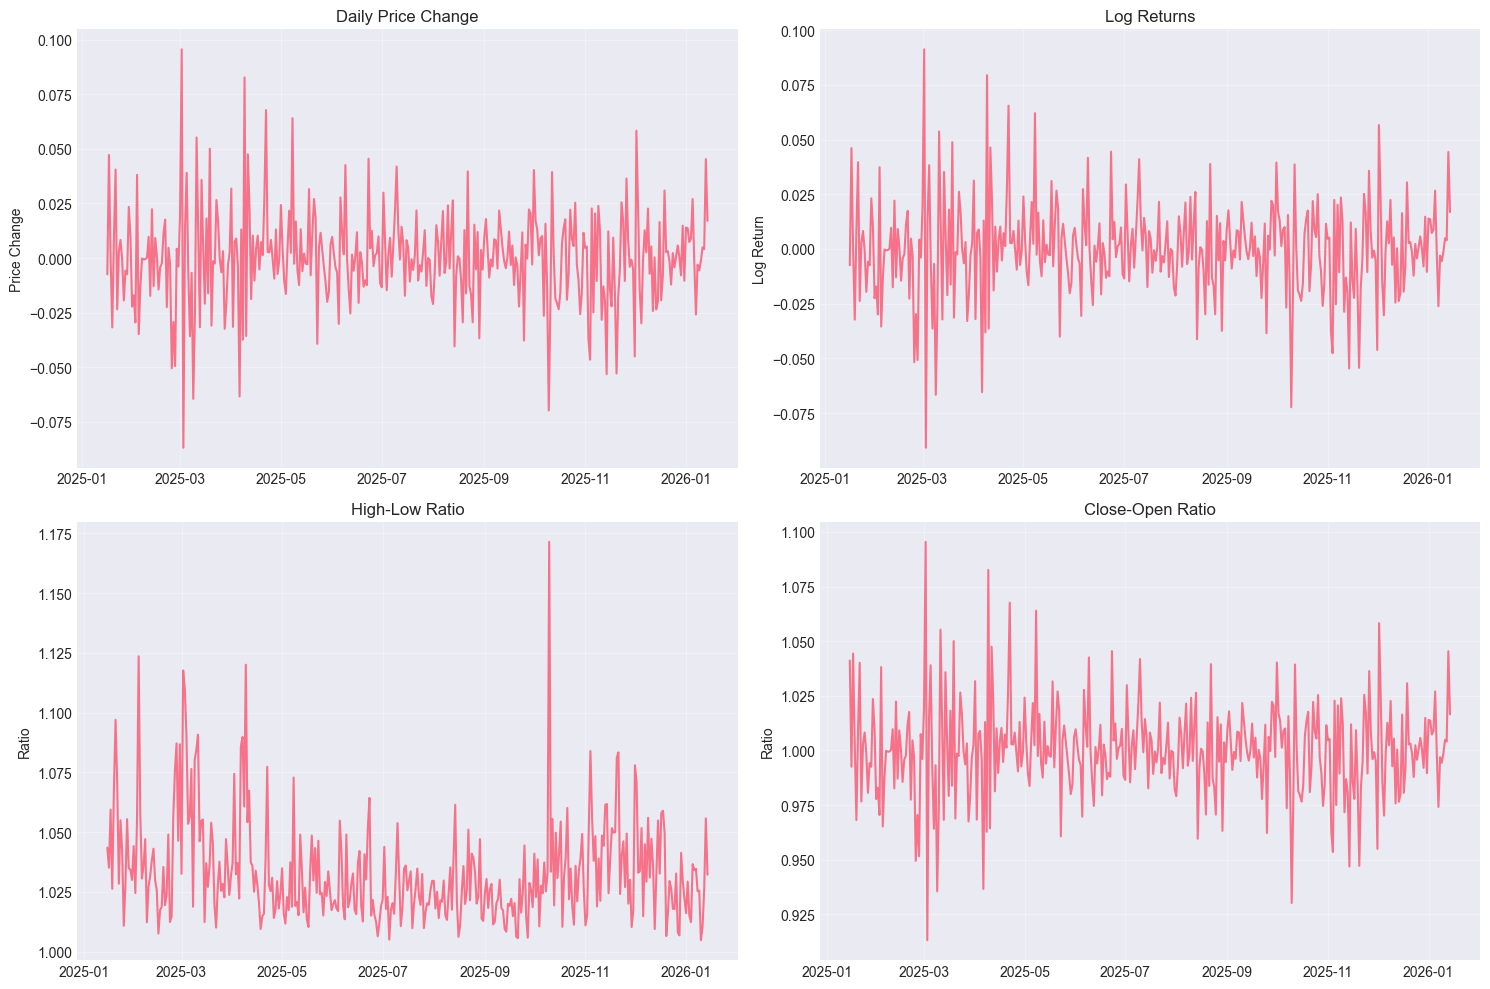

In [4]:
# Create a copy for feature engineering
df = data.copy()

# Add basic price-based features
df['Price_Change'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['High_Low_Ratio'] = df['High'] / df['Low']
df['Close_Open_Ratio'] = df['Close'] / df['Open']

# Plot basic features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price Change
axes[0, 0].plot(df.index, df['Price_Change'])
axes[0, 0].set_title('Daily Price Change')
axes[0, 0].set_ylabel('Price Change')
axes[0, 0].grid(True, alpha=0.3)

# Log Return
axes[0, 1].plot(df.index, df['Log_Return'])
axes[0, 1].set_title('Log Returns')
axes[0, 1].set_ylabel('Log Return')
axes[0, 1].grid(True, alpha=0.3)

# High-Low Ratio
axes[1, 0].plot(df.index, df['High_Low_Ratio'])
axes[1, 0].set_title('High-Low Ratio')
axes[1, 0].set_ylabel('Ratio')
axes[1, 0].grid(True, alpha=0.3)

# Close-Open Ratio
axes[1, 1].plot(df.index, df['Close_Open_Ratio'])
axes[1, 1].set_title('Close-Open Ratio')
axes[1, 1].set_ylabel('Ratio')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Moving Averages

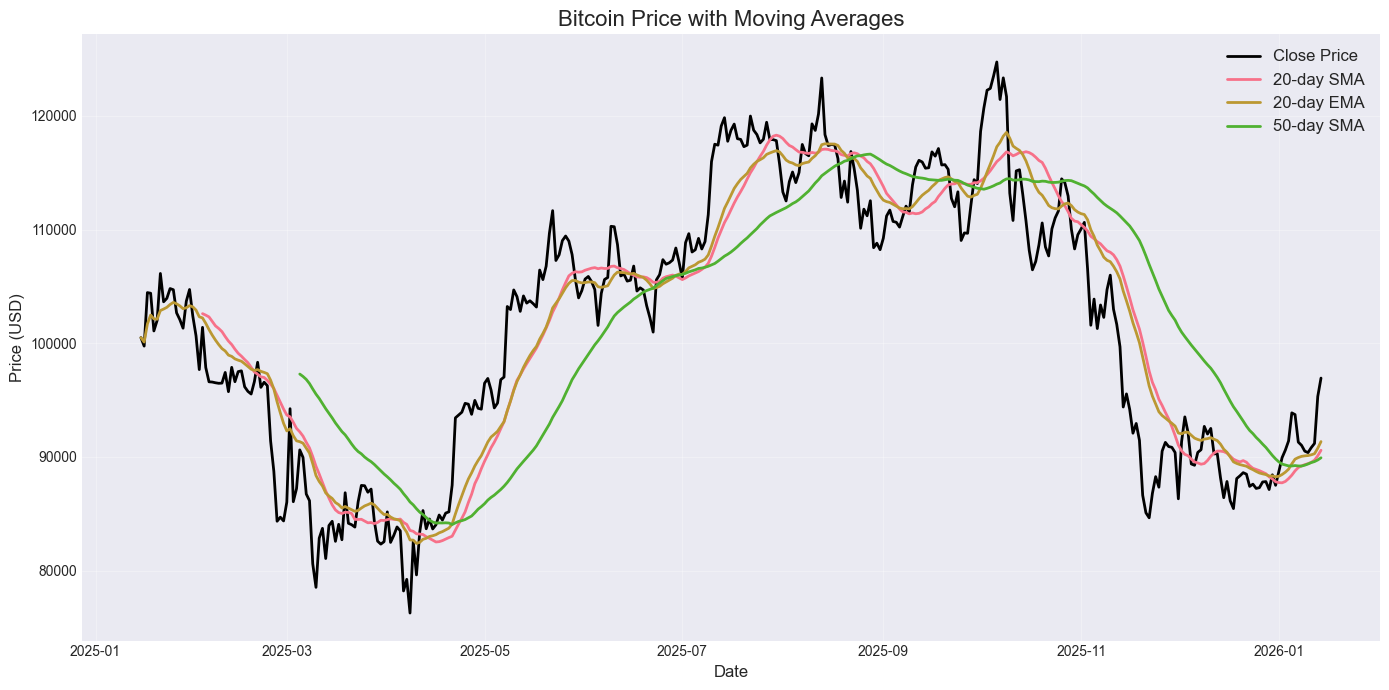

In [5]:
# Add moving averages
for window in [5, 10, 20, 50]:
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'EMA_{window}'] = df['Close'].ewm(span=window).mean()

# Plot moving averages
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2, color='black')
plt.plot(df.index, df['SMA_20'], label='20-day SMA', linewidth=2)
plt.plot(df.index, df['EMA_20'], label='20-day EMA', linewidth=2)
plt.plot(df.index, df['SMA_50'], label='50-day SMA', linewidth=2)

plt.title('Bitcoin Price with Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

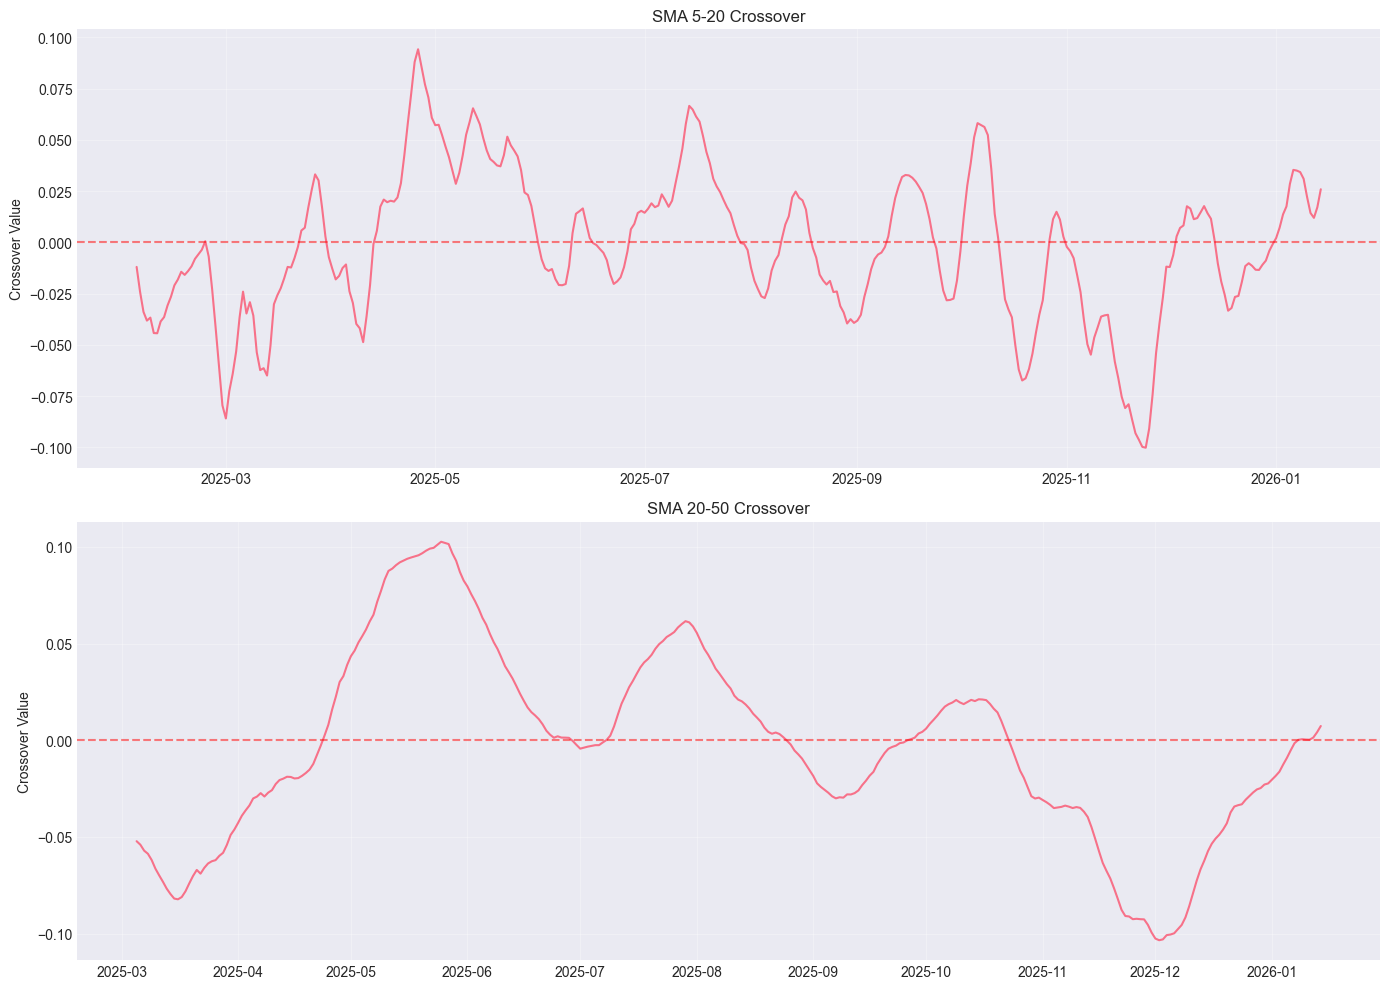

In [6]:
# Add moving average crossovers
df['SMA_5_20_Cross'] = df['SMA_5'] / df['SMA_20'] - 1
df['SMA_20_50_Cross'] = df['SMA_20'] / df['SMA_50'] - 1

# Plot crossovers
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# SMA 5-20 Crossover
axes[0].plot(df.index, df['SMA_5_20_Cross'])
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title('SMA 5-20 Crossover')
axes[0].set_ylabel('Crossover Value')
axes[0].grid(True, alpha=0.3)

# SMA 20-50 Crossover
axes[1].plot(df.index, df['SMA_20_50_Cross'])
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('SMA 20-50 Crossover')
axes[1].set_ylabel('Crossover Value')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Momentum Indicators

In [7]:
# Initialize feature engineer
engineer = FeatureEngineer()

In [8]:
# Add technical indicators using our feature engineer
df_with_indicators = engineer.add_technical_indicators(data)

# Check which indicators were successfully added
print(f"Added {len(df_with_indicators.columns)} columns")
print("Available columns:", df_with_indicators.columns.tolist())

Added 94 columns
Available columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'Price_Change', 'Log_Return', 'High_Low_Ratio', 'Close_Open_Ratio', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'SMA_5_20_Cross', 'SMA_20_50_Cross', 'RSI', 'Stoch_K', 'Stoch_D', 'Williams_R', 'UO', 'MACD', 'MACD_Signal', 'MACD_Diff', 'ADX', 'CCI', 'DMI_Pos', 'DMI_Neg', 'AROON_Up', 'AROON_Down', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Width', 'BB_Position', 'ATR', 'Keltner_High', 'Keltner_Low', 'Donchian_High', 'Donchian_Low', 'Volume_SMA', 'Volume_Ratio', 'OBV', 'VWAP', 'ADI', 'MFI', 'FI', 'EMV', 'VPT', 'NVI', 'PVI', 'Volatility', 'Skewness', 'Kurtosis', 'Day_of_Week', 'Month', 'Quarter', 'Day_of_Month', 'Week_of_Year', 'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2', 'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_5', 'Volume_Lag_5', 'Close_Lag_10', 'Volume_Lag_10', 'Close_Mean_5', 'Close_Std_5', 'Close_Max_5', 'Close_Min_5', 'Close_Range_5', 'Volume_Mean_

Available momentum indicators: ['RSI', 'Stoch_K', 'Stoch_D', 'Williams_R', 'UO']
Momentum Indicators:
              RSI     Stoch_K     Stoch_D  Williams_R          UO
count  316.000000  316.000000  316.000000  316.000000  316.000000
mean    51.205171   54.771871   54.606497  -45.228129   52.601006
std     11.443511   28.392751   26.563259   28.392751    8.910724
min     23.086270    0.859416    6.036688  -99.140584   29.070265
25%     42.625163   33.040634   30.908106  -66.959366   46.491914
50%     49.885830   55.661624   53.478148  -44.338376   51.973150
75%     59.092626   81.971920   80.027089  -18.028080   58.830115
max     78.479722  100.000000   96.349832   -0.000000   74.873971


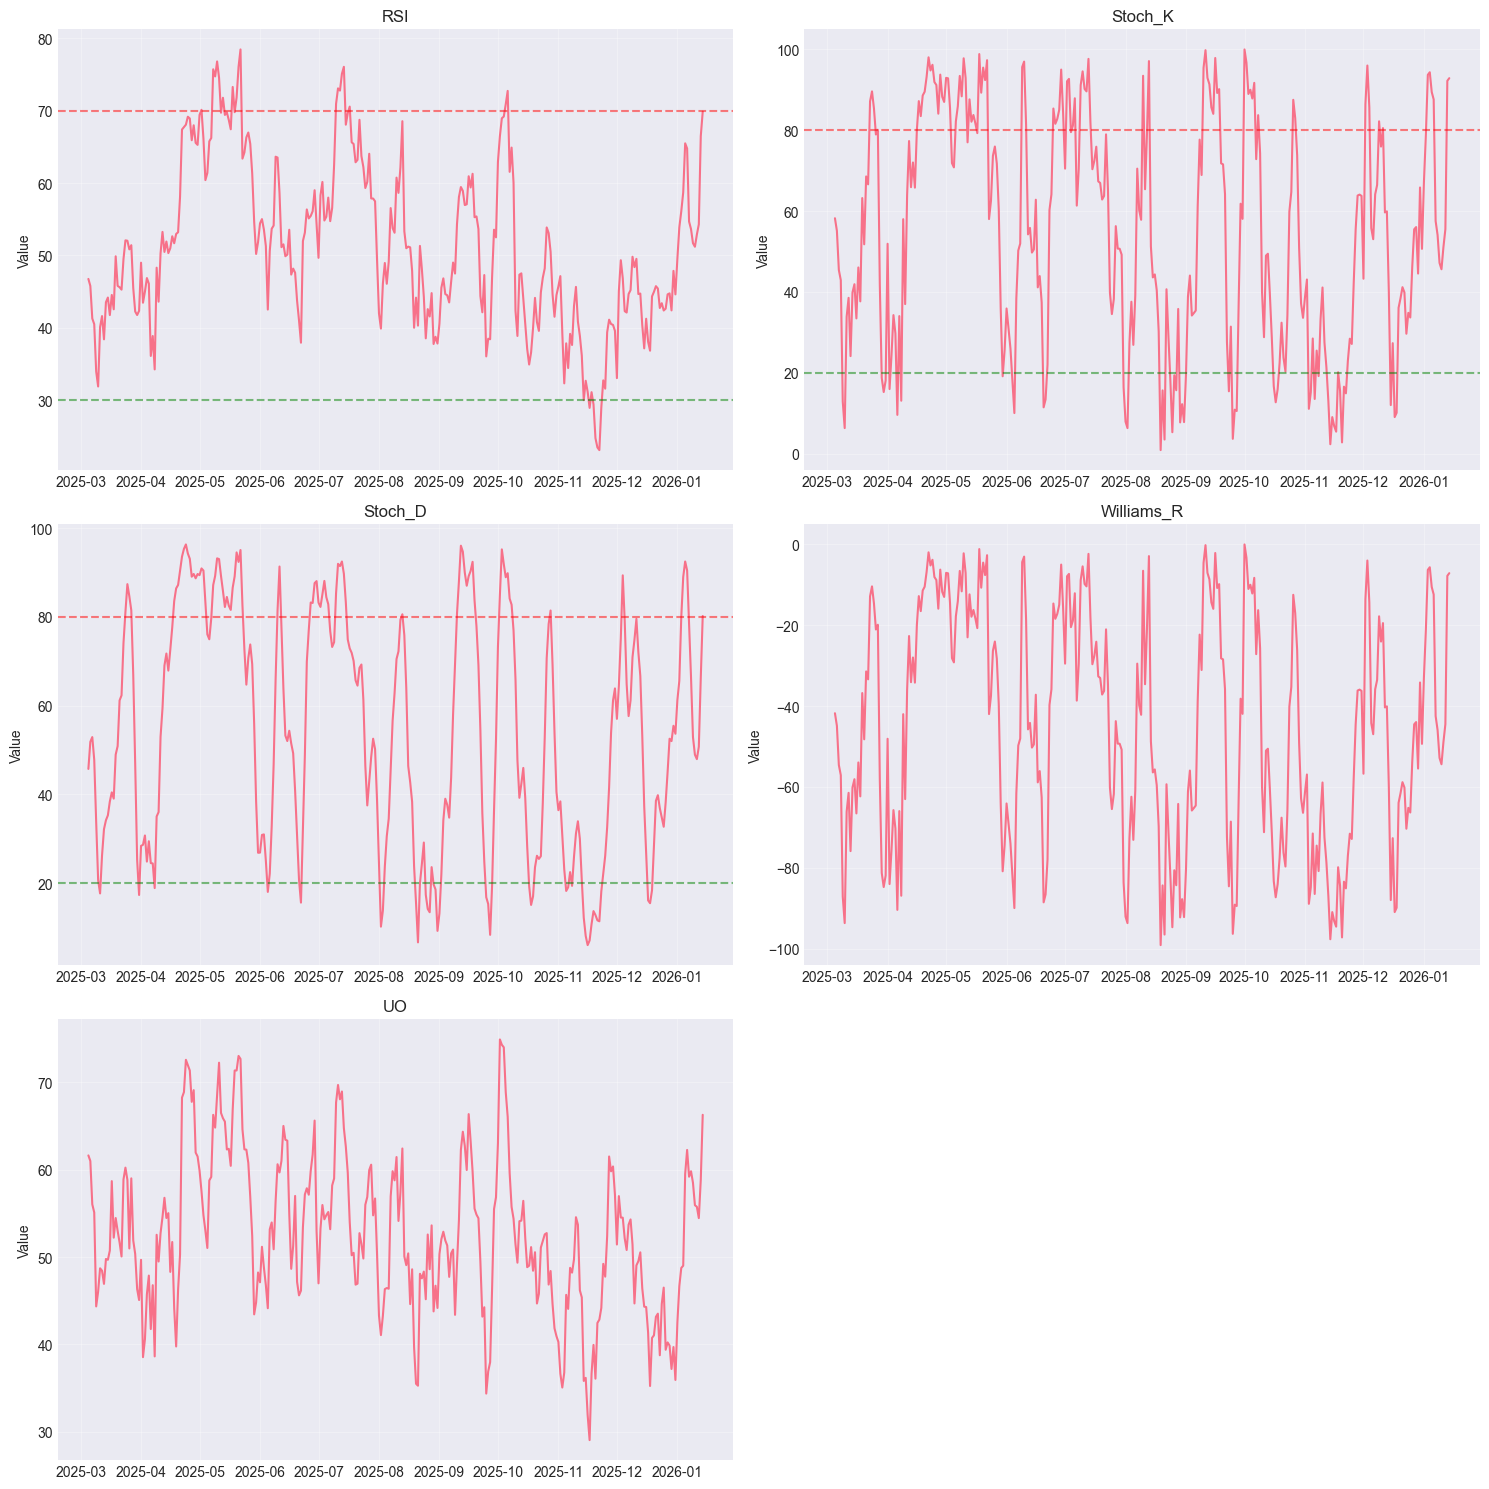

In [9]:
# Check for momentum indicators specifically
momentum_cols = ['RSI', 'Stoch_K', 'Stoch_D', 'Williams_R', 'UO']
available_momentum = [col for col in momentum_cols if col in df_with_indicators.columns]
print(f"Available momentum indicators: {available_momentum}")

if available_momentum:
    print("Momentum Indicators:")
    print(df_with_indicators[available_momentum].describe())
    
    # Plot momentum indicators
    n_cols = len(available_momentum)
    n_rows = (n_cols + 1) // 2  # Ensure we have enough rows
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(available_momentum):
        if i < len(axes):
            axes[i].plot(df_with_indicators.index, df_with_indicators[col])
            axes[i].set_title(col)
            axes[i].set_ylabel('Value')
            axes[i].grid(True, alpha=0.3)
            
            # Add reference lines if applicable
            if col == 'RSI':
                axes[i].axhline(y=70, color='red', linestyle='--', alpha=0.5)
                axes[i].axhline(y=30, color='green', linestyle='--', alpha=0.5)
            elif col in ['Stoch_K', 'Stoch_D']:
                axes[i].axhline(y=80, color='red', linestyle='--', alpha=0.5)
                axes[i].axhline(y=20, color='green', linestyle='--', alpha=0.5)
    
    # Hide unused subplots
    for i in range(len(available_momentum), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No momentum indicators available to display")

## 5. Trend Indicators

Trend Indicators:
              MACD  MACD_Signal    MACD_Diff         ADX         CCI
count   316.000000   316.000000   316.000000  316.000000  316.000000
mean   -109.387878  -151.209605    41.821727   24.591435    6.838185
std    2205.419286  2115.574839   610.717004    8.053024  109.418539
min   -5927.453238 -5189.058556 -1528.814888    9.482775 -320.436751
25%   -1567.363503 -1496.057800  -414.025382   18.119357  -71.053622
50%    -108.385797   -23.748981    82.353692   23.557823   -2.985162
75%    1148.643320  1237.945819   520.716287   29.955232   81.336990
max    4228.816824  3915.580606  1382.336198   47.613588  292.862399


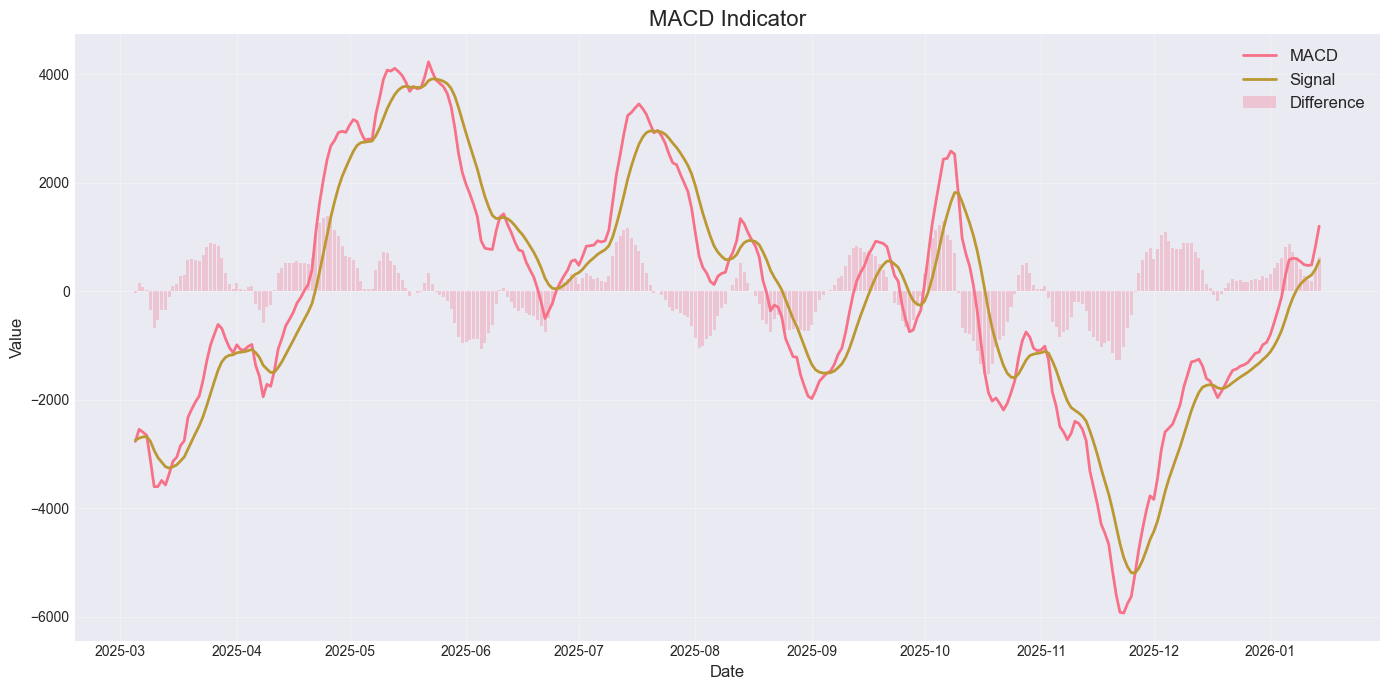

In [10]:
# Display trend indicators
trend_cols = ['MACD', 'MACD_Signal', 'MACD_Diff', 'ADX', 'CCI']
print("Trend Indicators:")
print(df_with_indicators[trend_cols].describe())

# Plot MACD
plt.figure(figsize=(14, 7))
plt.plot(df_with_indicators.index, df_with_indicators['MACD'], label='MACD', linewidth=2)
plt.plot(df_with_indicators.index, df_with_indicators['MACD_Signal'], label='Signal', linewidth=2)
plt.bar(df_with_indicators.index, df_with_indicators['MACD_Diff'], alpha=0.3, label='Difference')

plt.title('MACD Indicator', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

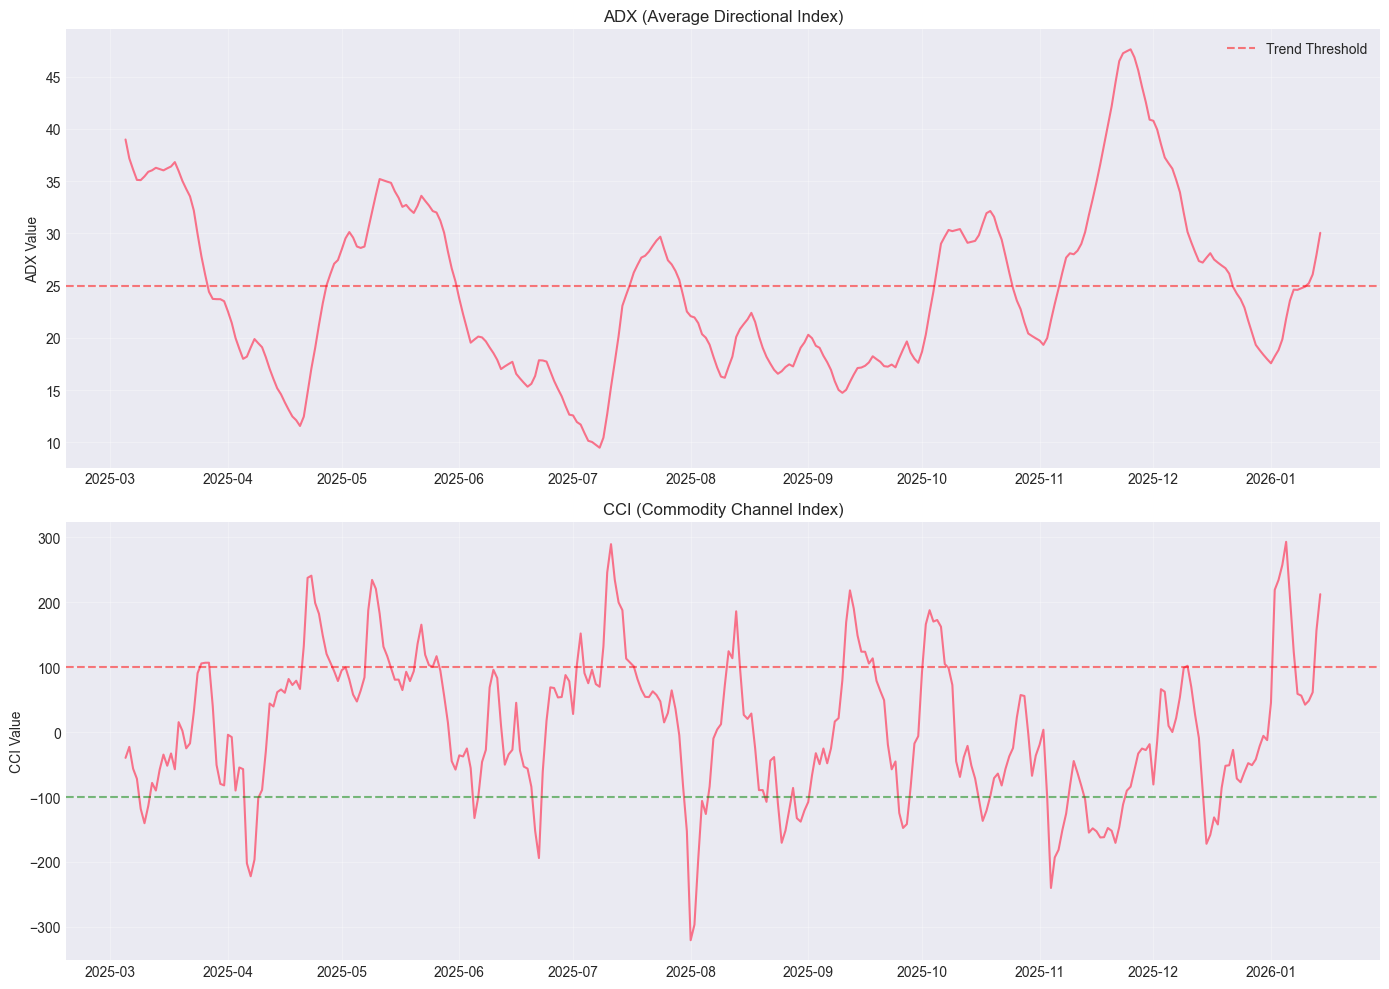

In [11]:
# Plot ADX and CCI
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ADX
axes[0].plot(df_with_indicators.index, df_with_indicators['ADX'])
axes[0].axhline(y=25, color='red', linestyle='--', alpha=0.5, label='Trend Threshold')
axes[0].set_title('ADX (Average Directional Index)')
axes[0].set_ylabel('ADX Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CCI
axes[1].plot(df_with_indicators.index, df_with_indicators['CCI'])
axes[1].axhline(y=100, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(y=-100, color='green', linestyle='--', alpha=0.5)
axes[1].set_title('CCI (Commodity Channel Index)')
axes[1].set_ylabel('CCI Value')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Volatility Indicators

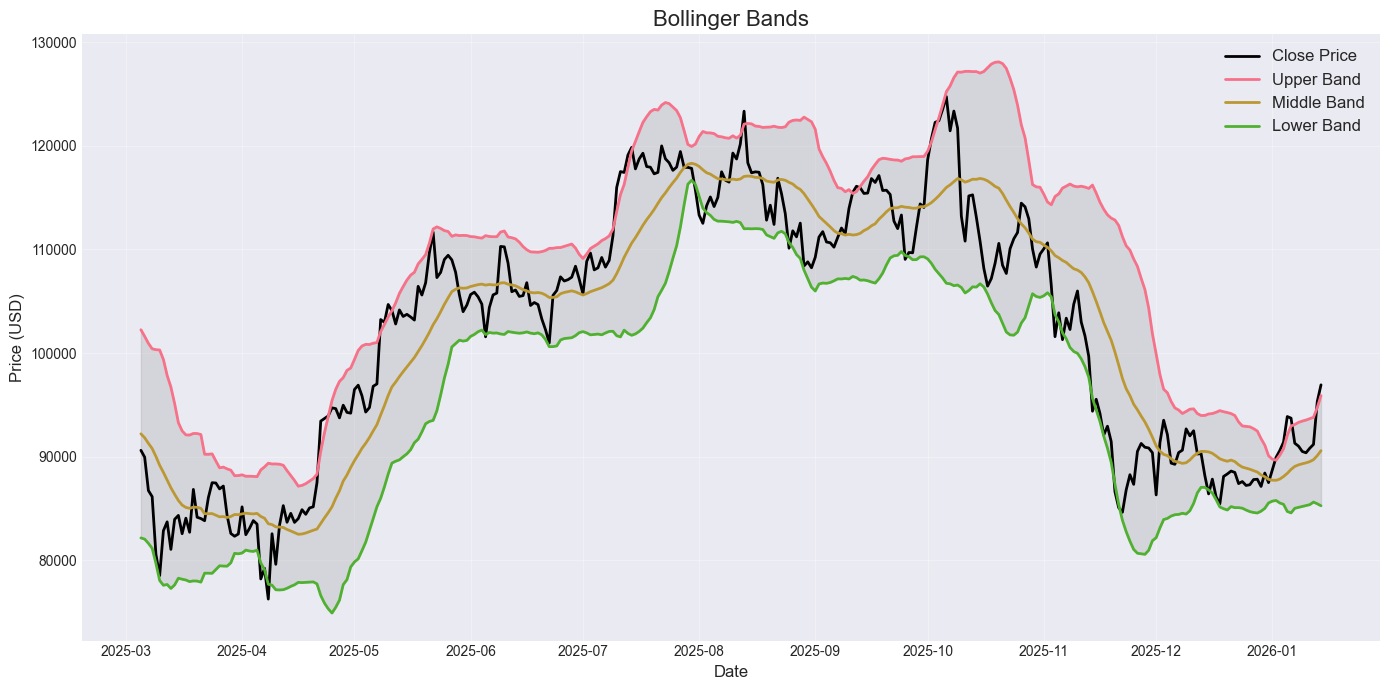

In [12]:
# Plot Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(df_with_indicators.index, df_with_indicators['Close'], label='Close Price', linewidth=2, color='black')
plt.plot(df_with_indicators.index, df_with_indicators['BB_Upper'], label='Upper Band', linewidth=2)
plt.plot(df_with_indicators.index, df_with_indicators['BB_Middle'], label='Middle Band', linewidth=2)
plt.plot(df_with_indicators.index, df_with_indicators['BB_Lower'], label='Lower Band', linewidth=2)

# Fill between bands
plt.fill_between(df_with_indicators.index, 
                 df_with_indicators['BB_Upper'], 
                 df_with_indicators['BB_Lower'], 
                 color='gray', alpha=0.2)

plt.title('Bollinger Bands', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

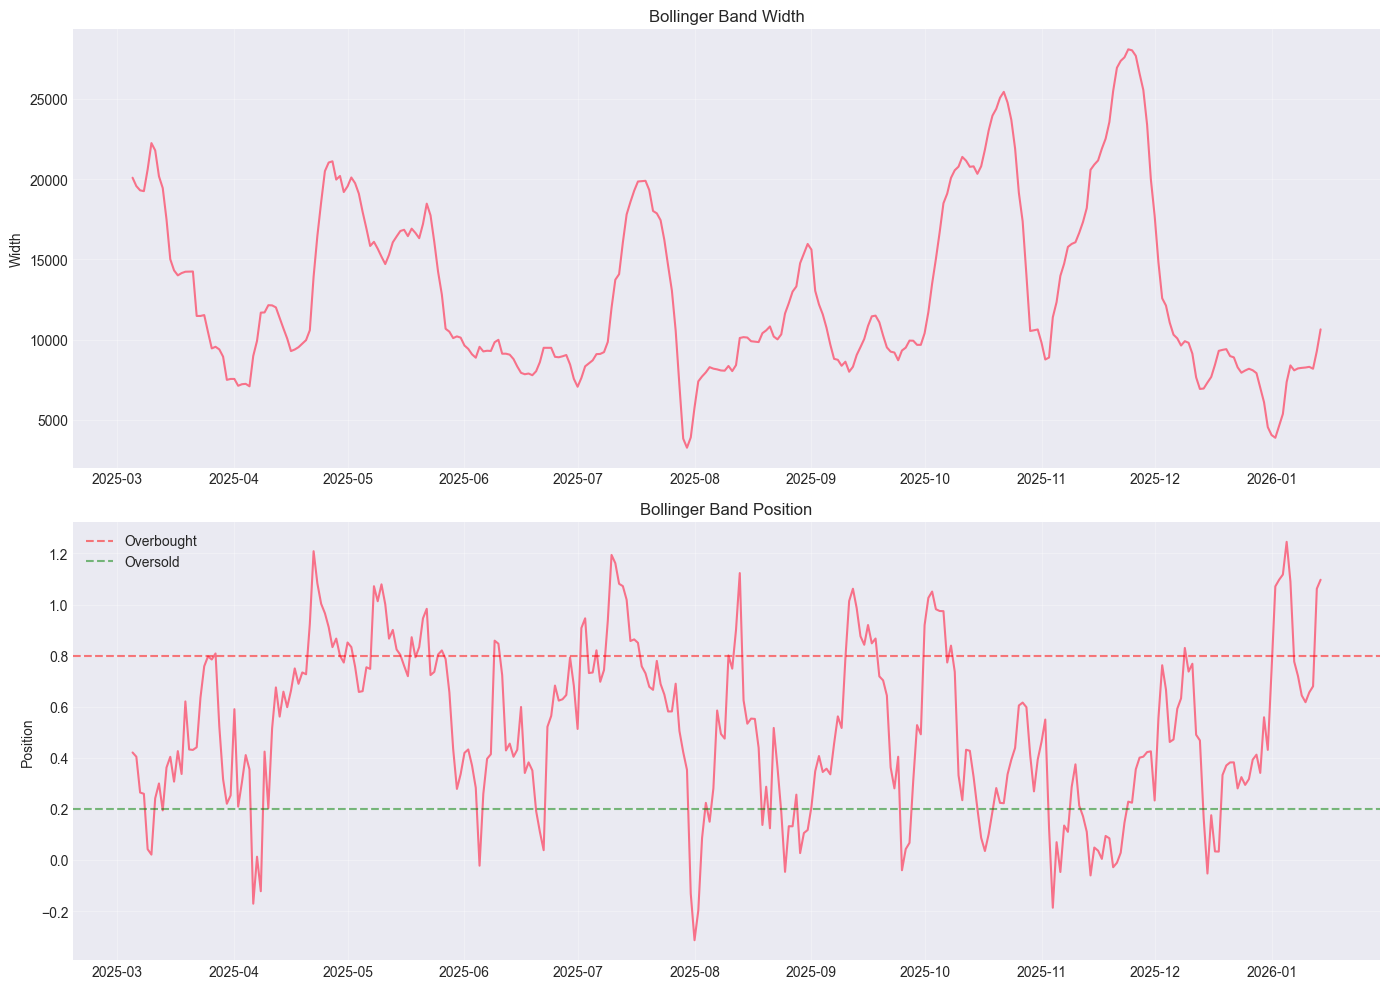

In [13]:
# Plot Bollinger Band Width and Position
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Bollinger Band Width
axes[0].plot(df_with_indicators.index, df_with_indicators['BB_Width'])
axes[0].set_title('Bollinger Band Width')
axes[0].set_ylabel('Width')
axes[0].grid(True, alpha=0.3)

# Bollinger Band Position
axes[1].plot(df_with_indicators.index, df_with_indicators['BB_Position'])
axes[1].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Overbought')
axes[1].axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Oversold')
axes[1].set_title('Bollinger Band Position')
axes[1].set_ylabel('Position')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Volume Indicators

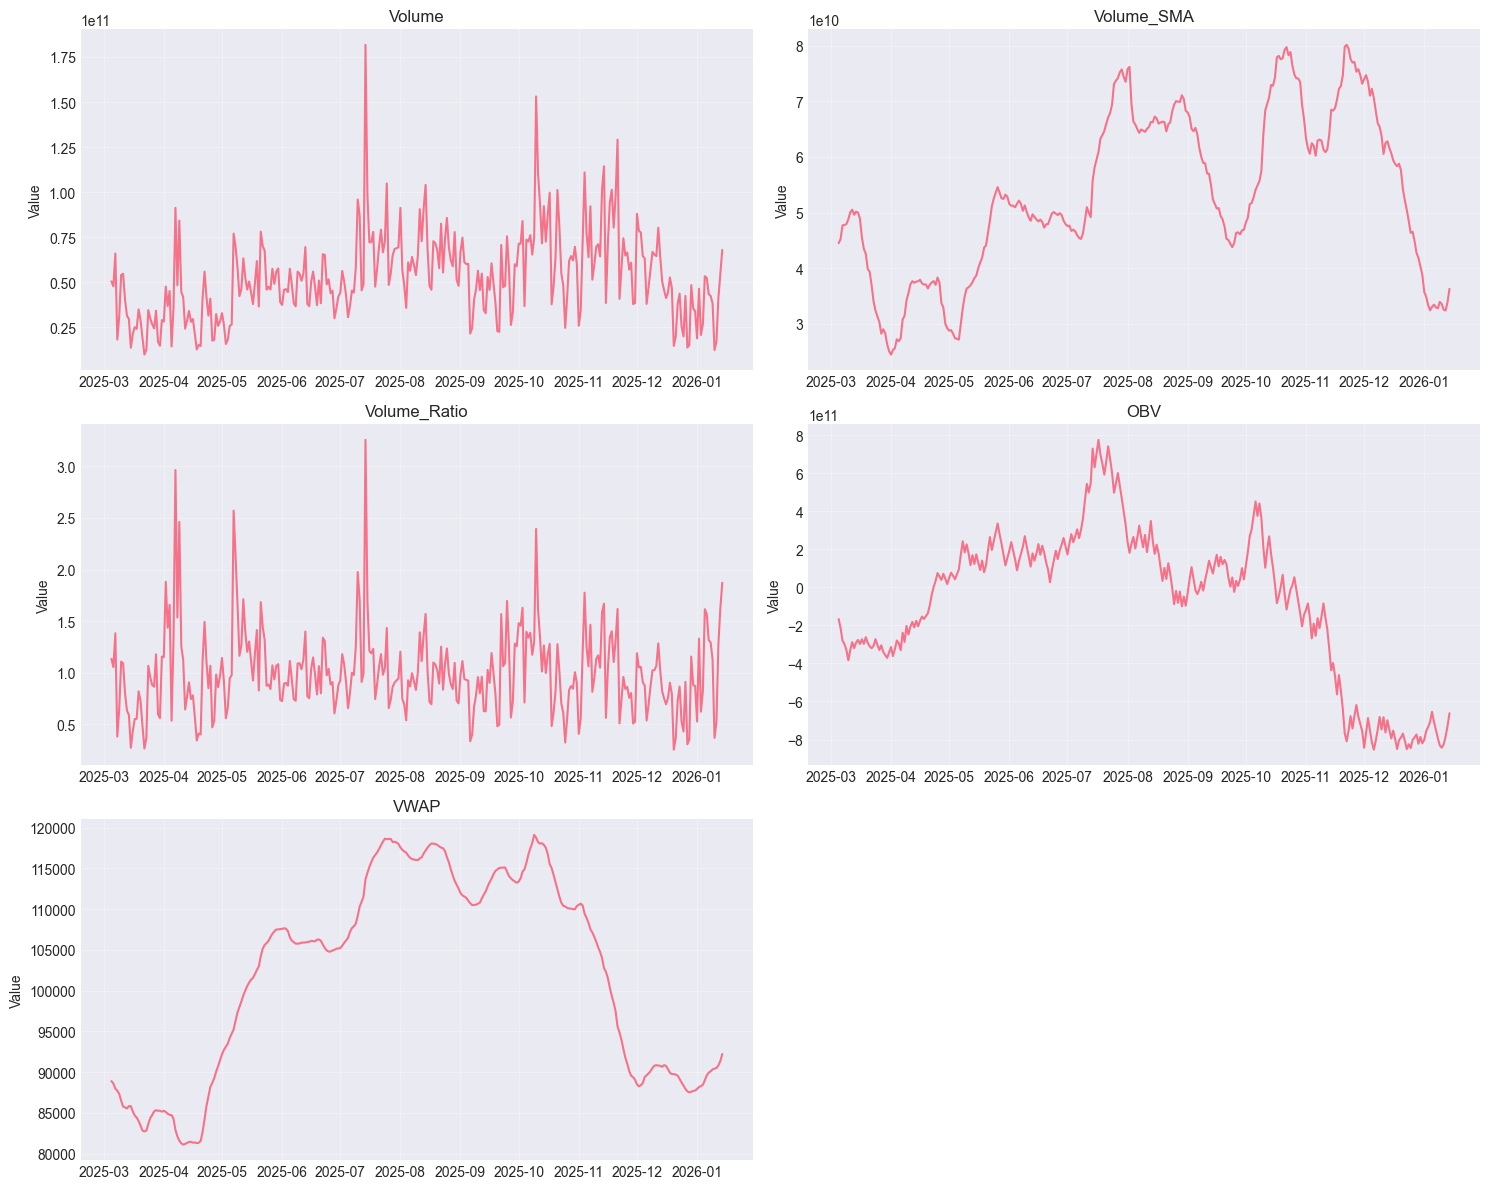

In [15]:
# Plot volume indicators
volume_cols = ['Volume', 'Volume_SMA', 'Volume_Ratio', 'OBV', 'VWAP']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(volume_cols):
    if i < len(axes) and col in df_with_indicators.columns:
        axes[i].plot(df_with_indicators.index, df_with_indicators[col])
        axes[i].set_title(col)
        axes[i].set_ylabel('Value')
        axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(len(available_momentum), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

## 8. Statistical Features

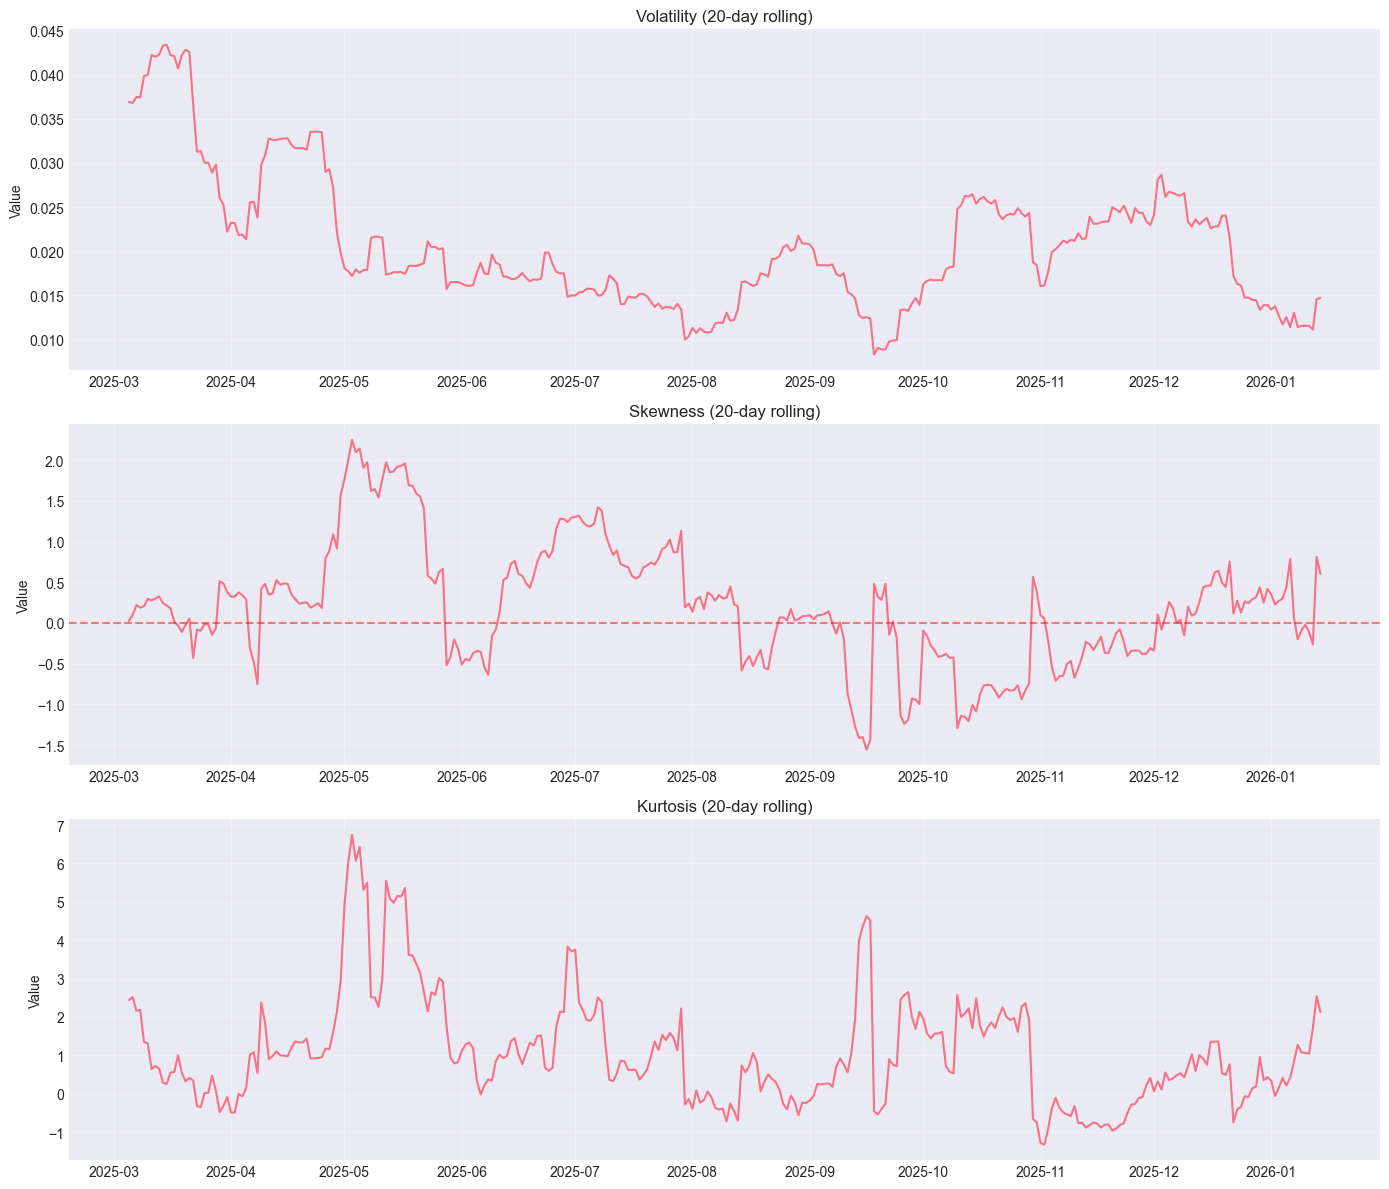

In [16]:
# Plot statistical features
stat_cols = ['Volatility', 'Skewness', 'Kurtosis']

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for i, col in enumerate(stat_cols):
    if col in df_with_indicators.columns:
        axes[i].plot(df_with_indicators.index, df_with_indicators[col])
        axes[i].set_title(f'{col} (20-day rolling)')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, alpha=0.3)
        
        # Add zero line for skewness
        if col == 'Skewness':
            axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 9. Time-Based Features

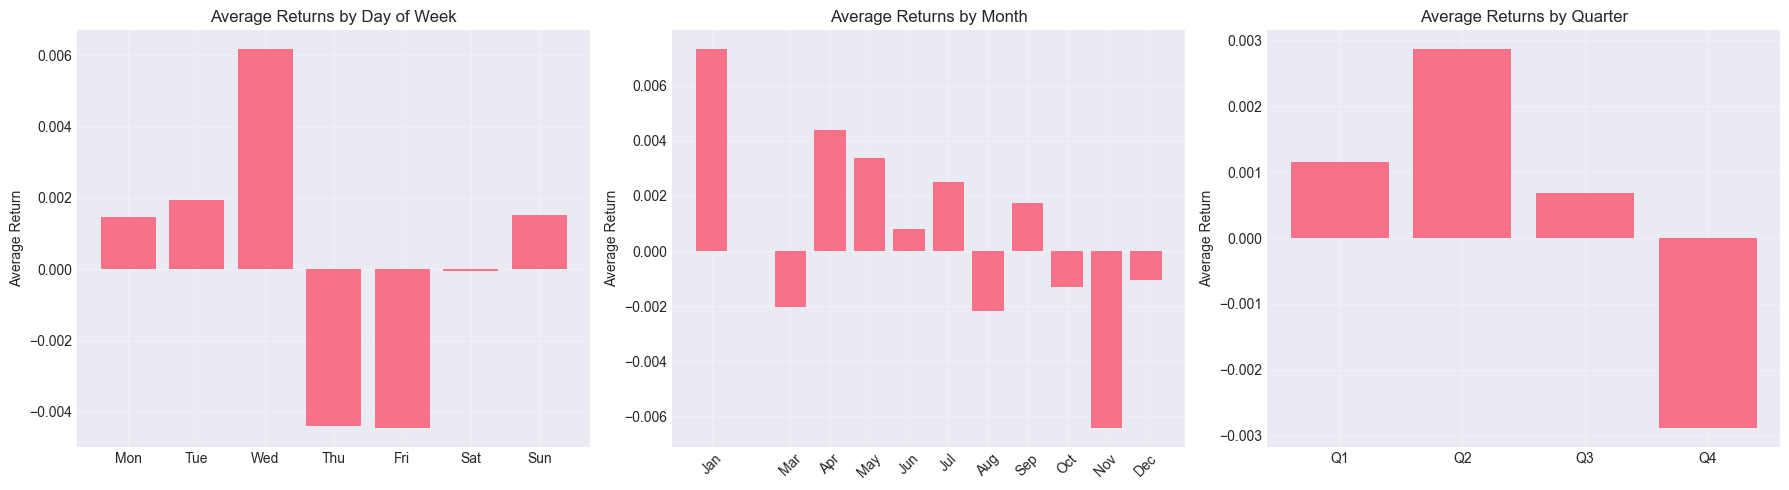

In [24]:
# Analyze time-based patterns
time_cols = ['Day_of_Week', 'Month', 'Quarter']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Day of Week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_returns = df_with_indicators.groupby('Day_of_Week')['Log_Return'].mean()
axes[0].bar(range(len(day_returns)), day_returns.values)
axes[0].set_xticks(range(len(day_returns)))
axes[0].set_xticklabels(day_names)
axes[0].set_title('Average Returns by Day of Week')
axes[0].set_ylabel('Average Return')
axes[0].grid(True, alpha=0.3)

# Month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_returns = df_with_indicators.groupby('Month')['Log_Return'].mean()
# axes[1].bar(range(len(month_returns)), month_returns.values)
# axes[1].set_xticks(range(len(month_returns)))
axes[1].bar(month_returns.index, month_returns.values)
axes[1].set_xticks(month_returns.index)

# axes[1].set_xticklabels(month_names, rotation=45)
axes[1].set_xticklabels(
    [month_names[m - 1] for m in month_returns.index],
    rotation=45
)

axes[1].set_title('Average Returns by Month')
axes[1].set_ylabel('Average Return')
axes[1].grid(True, alpha=0.3)

# Quarter
quarter_returns = df_with_indicators.groupby('Quarter')['Log_Return'].mean()
axes[2].bar(range(len(quarter_returns)), quarter_returns.values)
axes[2].set_xticks(range(len(quarter_returns)))
axes[2].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
axes[2].set_title('Average Returns by Quarter')
axes[2].set_ylabel('Average Return')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Feature Correlation Analysis

Top 20 Features Correlated with Close Price:
Low              0.993996
High             0.993786
EMA_5            0.989987
Open             0.986736
Close_Lag_1      0.986729
SMA_5            0.984690
Close_Mean_5     0.984690
Close_Min_5      0.982189
Close_Max_5      0.980463
EMA_10           0.975716
Close_Lag_2      0.973778
Close_Min_10     0.965866
SMA_10           0.965321
Close_Mean_10    0.965321
Close_Lag_3      0.961922
VWAP             0.953739
Close_Max_10     0.953490
EMA_20           0.945779
Close_Lag_5      0.938495
Keltner_Low      0.938032
dtype: float64


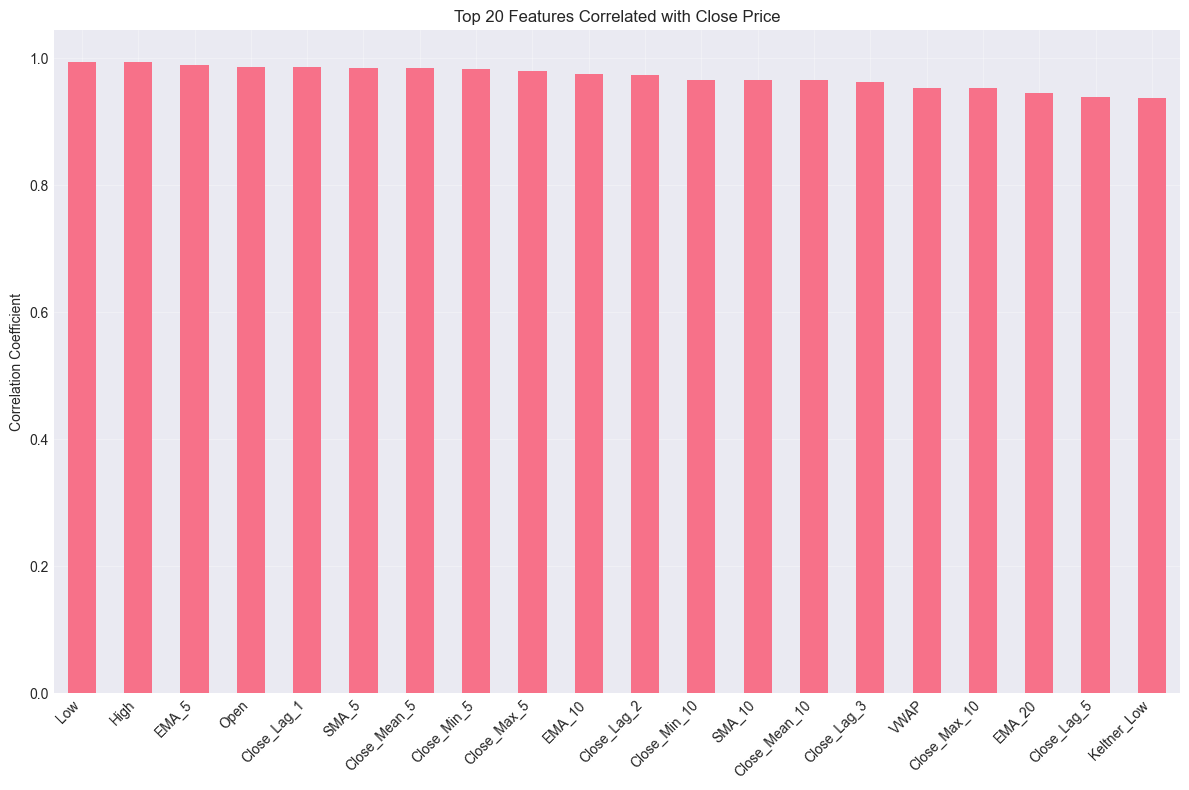

In [26]:
# Calculate correlation with target
feature_cols = df_with_indicators.select_dtypes(include='number').columns
feature_cols = feature_cols.drop('Close')

# Calculate correlation with target
correlations = df_with_indicators[feature_cols].corrwith(df_with_indicators['Close'])

# Get top correlated features
top_correlations = correlations.abs().sort_values(ascending=False).head(20)
print("Top 20 Features Correlated with Close Price:")
print(top_correlations)

# Plot top correlations
plt.figure(figsize=(12, 8))
top_correlations.plot(kind='bar')
plt.title('Top 20 Features Correlated with Close Price')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

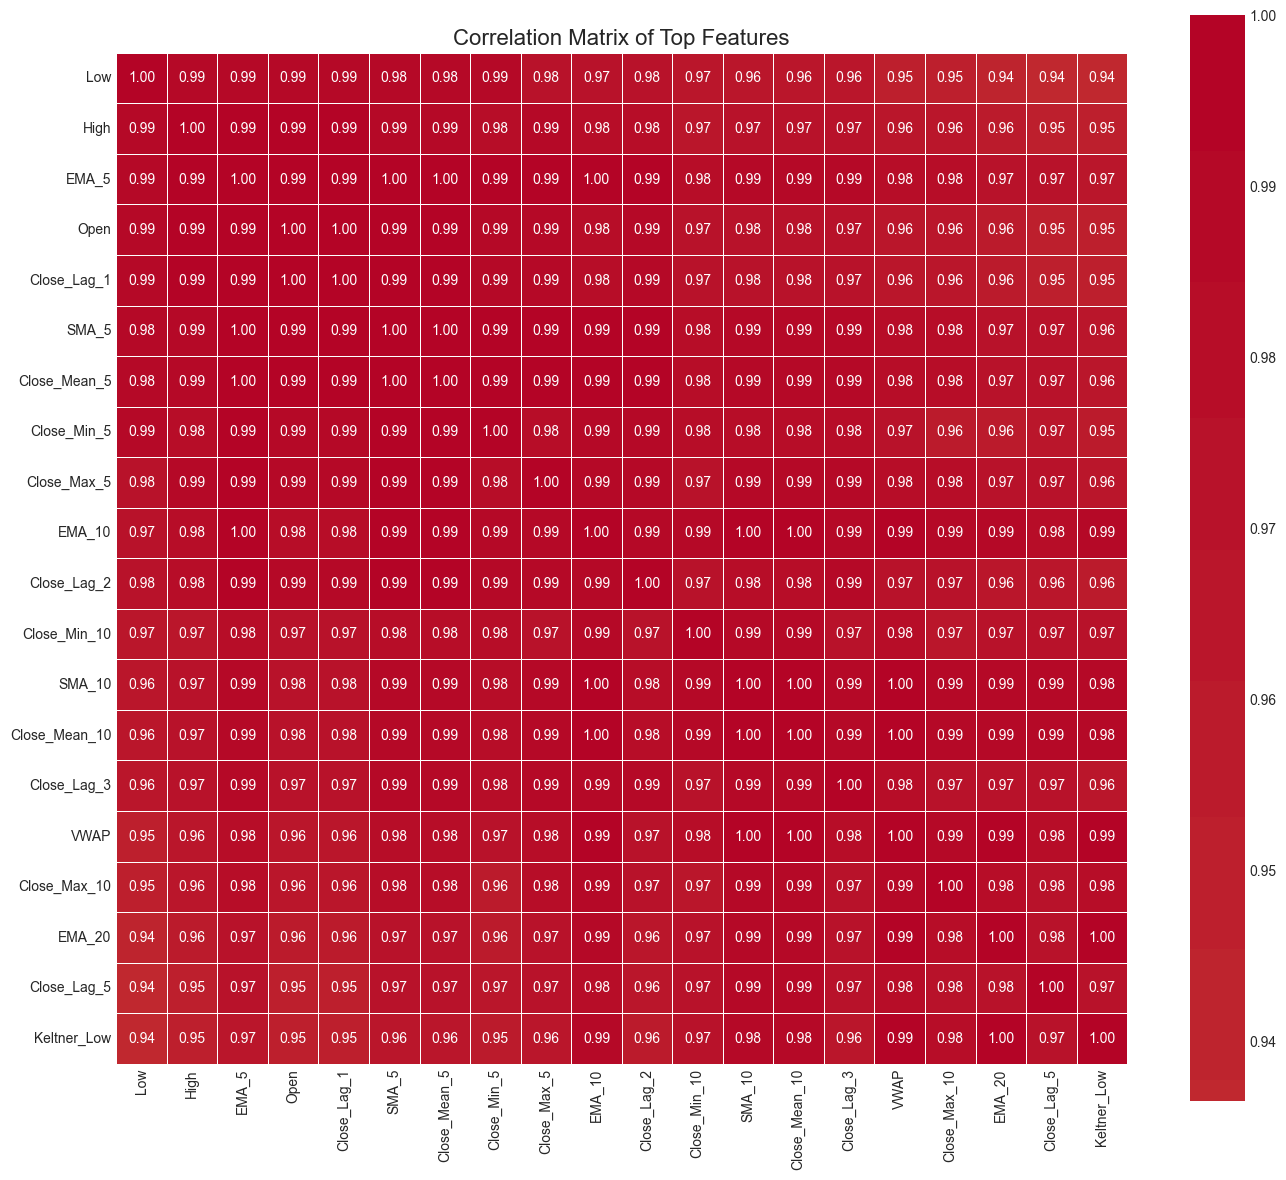

In [27]:
# Create correlation heatmap for top features
top_features = top_correlations.index.tolist()
correlation_matrix = df_with_indicators[top_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Top Features', fontsize=16)
plt.tight_layout()
plt.show()

## 11. Feature Selection

In [28]:
# Select features using different methods
selection_methods = ['correlation', 'mutual_info', 'variance']
selected_features = {}

for method in selection_methods:
    features = engineer.select_features(df_with_indicators, method=method, top_k=30)
    selected_features[method] = features
    print(f"\n{method.title()} method selected {len(features)} features:")
    print(features[:10])  # Show first 10

# Compare selected features
from collections import Counter

# Count feature occurrences across methods
feature_counts = Counter()
for features in selected_features.values():
    feature_counts.update(features)

# Get most commonly selected features
common_features = feature_counts.most_common(20)
print("\nMost Commonly Selected Features:")
for feature, count in common_features:
    print(f"{feature}: {count} methods")


Correlation method selected 30 features:
['Low', 'High', 'EMA_5', 'Open', 'Close_Lag_1', 'SMA_5', 'Close_Mean_5', 'Close_Min_5', 'Close_Max_5', 'EMA_10']

Mutual_Info method selected 30 features:
['High', 'Low', 'Close_Max_5', 'EMA_5', 'Close_Min_5', 'Open', 'Close_Lag_1', 'PVI', 'Close_Mean_5', 'SMA_5']

Variance method selected 30 features:
['Donchian_Low', 'Close_Lag_5', 'Close_Max_10', 'Low', 'Close_Lag_2', 'Close_Lag_3', 'Open', 'Close_Lag_1', 'Close_Max_5', 'Close_Min_5']

Most Commonly Selected Features:
Low: 3 methods
High: 3 methods
EMA_5: 3 methods
Open: 3 methods
Close_Lag_1: 3 methods
SMA_5: 3 methods
Close_Mean_5: 3 methods
Close_Min_5: 3 methods
Close_Max_5: 3 methods
EMA_10: 3 methods
Close_Lag_2: 3 methods
Close_Min_10: 3 methods
SMA_10: 3 methods
Close_Mean_10: 3 methods
Close_Lag_3: 3 methods
VWAP: 3 methods
Close_Max_10: 3 methods
EMA_20: 3 methods
Close_Lag_5: 3 methods
Keltner_Low: 3 methods


## 12. Feature Importance Analysis

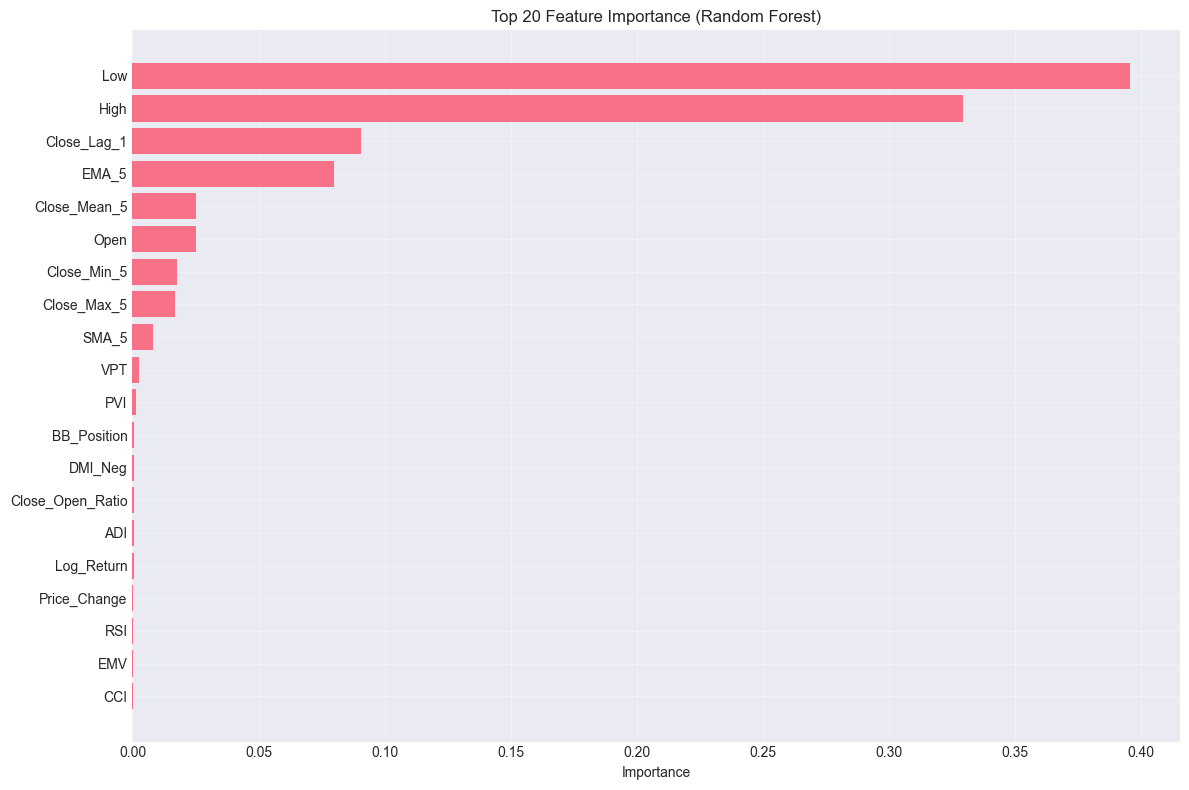

In [29]:
# Use Random Forest to get feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Prepare data
df_clean = df_with_indicators.dropna()
X = df_clean[feature_cols]
y = df_clean['Close']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importance
importance = rf.feature_importances_
feature_importance = pd.DataFrame({'feature': feature_cols, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 important features
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(top_20['feature'], top_20['importance'])
plt.title('Top 20 Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Create Sequences for Modeling

In [31]:
# Create sequences using selected features
# selected_feature_list = common_features[:15]  # Use top 15 common features
# engineer.feature_columns = selected_feature_list
# Extract just the feature names from the tuples
selected_feature_list = [feature[0] for feature in common_features[:15]]  # Use top 15 common features
engineer.feature_columns = selected_feature_list

# Check if all selected features exist in the dataframe
existing_features = [col for col in selected_feature_list if col in df_with_indicators.columns]
missing_features = [col for col in selected_feature_list if col not in df_with_indicators.columns]

print(f"Selected {len(selected_feature_list)} features")
print(f"Found {len(existing_features)} features in dataframe")
print(f"Missing {len(missing_features)} features: {missing_features}")

# Use only the features that exist
if missing_features:
    print(f"Using only existing features: {existing_features}")
    engineer.feature_columns = existing_features


Selected 15 features
Found 15 features in dataframe
Missing 0 features: []


In [32]:
# Create sequences with different window sizes
window_sizes = [7, 14, 30]

for window_size in window_sizes:
    X, y = engineer.create_sequences(
        df_with_indicators, 
        sequence_length=window_size,
        prediction_horizon=1
    )
    
    print(f"\nWindow Size: {window_size}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Sample X[0]:\n{X[0][:3]}")  # Show first 3 timesteps
    print(f"Sample y[0]: {y[0]}")


Window Size: 7
X shape: (309, 7, 15)
y shape: (309,)
Sample X[0]:
[[86379.7734375  90998.2421875  88762.97579059 87222.953125
  87222.1953125  88838.3390625  88838.3390625  86031.9140625
  94248.3515625  89301.47184888 86065.671875   84347.0234375
  87777.0296875  87777.0296875  94248.3515625 ]
 [87852.140625   92804.9375     89162.55938164 90622.359375
  90623.5625     89624.3015625  89624.3015625  86065.671875
  94248.3515625  89421.52247272 87222.1953125  84347.0234375
  87631.38515625 87631.38515625 86065.671875  ]
 [84717.6796875  91191.046875   88355.9302122  89963.28125
  89961.7265625  88123.165625   88123.165625   86065.671875
  90623.5625     88934.44441274 90623.5625     84347.0234375
  87432.03515625 87432.03515625 87222.1953125 ]]
Sample y[0]: 83722.359375

Window Size: 14
X shape: (302, 14, 15)
y shape: (302,)
Sample X[0]:
[[86379.7734375  90998.2421875  88762.97579059 87222.953125
  87222.1953125  88838.3390625  88838.3390625  86031.9140625
  94248.3515625  89301.471848

## 14. Summary of Feature Engineering

### Key Features Created:

1. **Price-based Features**: Price changes, log returns, high-low ratios
2. **Moving Averages**: SMA and EMA for multiple windows
3. **Momentum Indicators**: RSI, Stochastic, Williams %R, Ultimate Oscillator
4. **Trend Indicators**: MACD, ADX, CCI, DMI
5. **Volatility Indicators**: Bollinger Bands, ATR, Keltner Channels
6. **Volume Indicators**: OBV, VWAP, Volume ratios
7. **Statistical Features**: Rolling volatility, skewness, kurtosis
8. **Time-based Features**: Day of week, month, quarter
9. **Lag Features**: Previous values for different time lags

### Feature Selection Methods:

1. **Correlation-based**: Select features highly correlated with target
2. **Mutual Information**: Select features with high mutual information
3. **Variance-based**: Select features with high variance
4. **Tree-based**: Use Random Forest feature importance

### Key Insights:

1. **Lag Features**: Recent prices and returns are most predictive
2. **Moving Averages**: Medium-term trends (20-50 days) are important
3. **Volatility**: Recent volatility is a strong predictor
4. **Volume**: Volume-related features provide additional information
5. **Technical Indicators**: RSI and MACD are among the most useful

These features will be used to train our deep learning models for cryptocurrency price prediction.